In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from svetlanna import elements
from svetlanna import SimulationParameters
from svetlanna import beam_generator

In [2]:
plt.style.use('science')

Let us find the numerical and analytical solution of the problem of free propagation of a Gaussian beam at distance $z_{total}$:

In [3]:
Nx = 3000
Ny = 3000

lx = 2
ly = 2

z = 150
z_total = 300
lam = 1064*1e-6
wave_number = 2 * torch.pi / lam
w0 = 1

# meshgrid
x = np.linspace(-lx/2, lx/2, Nx)
y = np.linspace(-ly/2, ly/2, Ny)
xv, yv = np.meshgrid(x, y)


params= SimulationParameters(
    x_size=lx,
    y_size=ly,
    x_nodes=Nx,
    y_nodes=Ny,
    wavelength=lam
)


Let us find the field and intensity distribution $I_{total}$ of the Gaussian beam after free propagation to the distance $z_{total}$:

In [4]:

field_gb_total = beam_generator.GaussianBeam(simulation_parameters=params).forward(distance=z_total, waist_radius=w0)
intensity_gb_total = torch.pow(torch.abs(field_gb_total), 2).detach().numpy()


Let's find the same field, but the last part of the $z_{end}$ path will be calculated using the Fresnel method:

In [5]:
z_end = 200
z_start = z_total - z_end

field_gb_start = beam_generator.GaussianBeam(simulation_parameters=params).forward(distance=z_start, waist_radius=w0)

field_gb_end = elements.FreeSpace(
    simulation_parameters=params, distance=z_end, method='fresnel'
    ).forward(input_field=field_gb_start)

intensity_gb_end = torch.pow(torch.abs(field_gb_end), 2).detach().numpy()

Let us look at two intensity profiles: $I_{total}$, obtained analytically, and $I_{F}$, obtained using Fresnel propagation method:

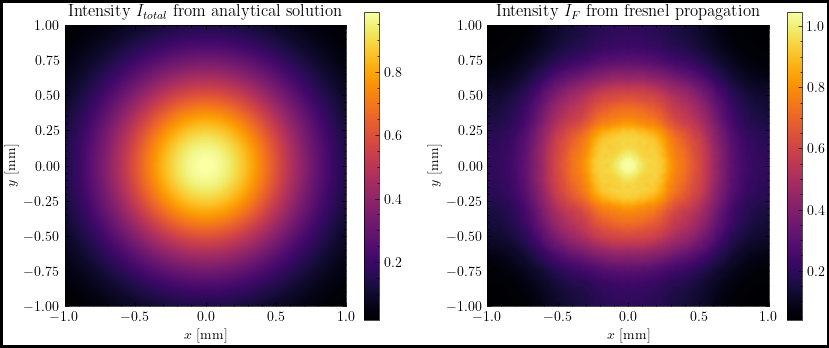

In [6]:
fig, ax = plt.subplots(
    1, 2, figsize=(10, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax[0].pcolormesh(xv, yv, intensity_gb_total, cmap='inferno')
ax[0].set_aspect('equal')
ax[0].set_title(r'Intensity $I_{total}$ from analytical solution')
ax[0].set_xlabel('$x$ [mm]')
ax[0].set_ylabel('$y$ [mm]')
fig.colorbar(im1)

im2 = ax[1].pcolormesh(xv, yv, intensity_gb_end, cmap='inferno')
ax[1].set_aspect('equal')
ax[1].set_title(r'Intensity $I_F$ from fresnel propagation')
ax[1].set_xlabel('$x$ [mm]')
ax[1].set_ylabel('$y$ [mm]')
fig.colorbar(im2)

We numerically and analytically solve the problem of free propagation of a Gaussian beam over distance $z_{total}$ for different numbers of computational nodes:

In [7]:
from tqdm import tqdm

node_array = np.linspace(100, 4000, 40, dtype=int)
node_array

std_list = []
energy_numeric_list = []
energy_analytic_list = []

for n in tqdm(node_array):

    x = np.linspace(-lx/2, lx/2, n)
    y = np.linspace(-ly/2, ly/2, n)
    xv, yv = np.meshgrid(x, y)

    dx = lx/n
    dy = ly/n

    params= SimulationParameters(
        x_size=lx,
        y_size=ly,
        x_nodes=n,
        y_nodes=n,
        wavelength=lam
    )


    field_gb_total = beam_generator.GaussianBeam(
        simulation_parameters=params
    ).forward(distance=z_total, waist_radius=w0)
    intensity_gb_total = torch.pow(torch.abs(field_gb_total), 2).detach().numpy()

    field_gb_start = beam_generator.GaussianBeam(
        simulation_parameters=params
    ).forward(distance=z_start, waist_radius=w0)
    field_gb_end = elements.FreeSpace(
        simulation_parameters=params, distance=z_end, method='fresnel'
    ).forward(input_field=field_gb_start)

    intensity_gb_end = torch.pow(torch.abs(field_gb_end), 2).detach().numpy()

    intensity_difference = intensity_gb_total - intensity_gb_end

    standard_deviation = np.std(intensity_difference)
    std_list.append(standard_deviation)

    energy_analytic = np.sum(intensity_gb_total)*dx*dy
    energy_numeric = np.sum(intensity_gb_end)*dx*dy

    energy_numeric_list.append(energy_numeric)
    energy_analytic_list.append(energy_analytic)



100%|██████████| 40/40 [00:41<00:00,  1.05s/it]


In [8]:
std_list = np.array(std_list)
energy_numeric_list = np.array(energy_numeric_list)
energy_analytic_list = np.array(energy_analytic_list)

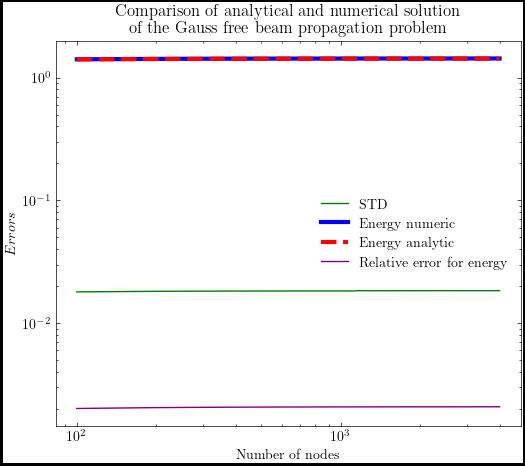

In [9]:
fig, ax = plt.subplots(figsize=(6, 5), edgecolor='black', linewidth=3,
                       frameon=True)

ax.loglog(node_array, std_list, color='green', label='STD')
ax.loglog(node_array, energy_numeric_list, color='blue', label='Energy numeric', linewidth=3)
ax.loglog(node_array, energy_analytic_list, color='red', label='Energy analytic', linestyle='dashed', linewidth=3)
ax.loglog(node_array, np.abs((energy_analytic_list - energy_numeric_list)/energy_analytic_list), color='purple', label='Relative error for energy')
ax.set_title('Comparison of analytical and numerical solution \n of the Gauss free beam propagation problem')
ax.set_xlabel('Number of nodes')
ax.set_ylabel(r'$Errors$')
ax.legend()